In [1]:
import pickle
from aemulusnu_massfunction.emulator import *
from aemulusnu_massfunction.fisher_utils import *

loading emulator from /home/users/delon/aemulusnu_massfunction/aemulusnu_massfunction/emulator.pkl


In [2]:
M = 10**np.linspace(9, 16, 300) #h^-1 Msol

In [3]:
plt.show()
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 32


In [4]:
import seaborn as sns

In [5]:
precomputed = {}

In [6]:
def kFS(OL, Om, z, mnu):
    #assume mnu is in units eV
    return 0.8 * np.sqrt(OL + Om*(1+z)**3)/(1+z)**2* mnu # h / Mpc

def R_FS(OL, Om, z, mnu):
    #comoving units 
    return 1 / kFS(OL, Om, z, mnu) # Mpc / h

ρcrit0 = 2.77533742639e+11 #h^2 Msol / Mpc^3

def R_FS_to_M_FS(OL, Om, z, mnu):
    rhom_0 = Om * ρcrit0
    rhom = rhom_0 *  redshiftToScale(z)**(-3)
    #Msol / h   
    return 4/3 * np.pi * R_FS(OL, Om, z, mnu) ** 3 * rhom

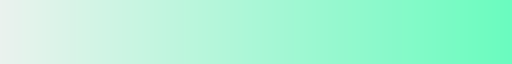

In [16]:
sns.light_palette("#6afcbfff", as_cmap=True)

In [7]:
plt.show()
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 11


loading emulator from /home/users/delon/aemulusnu_massfunction/aemulusnu_massfunction/emulator.pkl


50it [00:00, 2719.65it/s]
50it [00:00, 2811.61it/s]
50it [00:00, 2795.57it/s]
50it [00:00, 2807.51it/s]


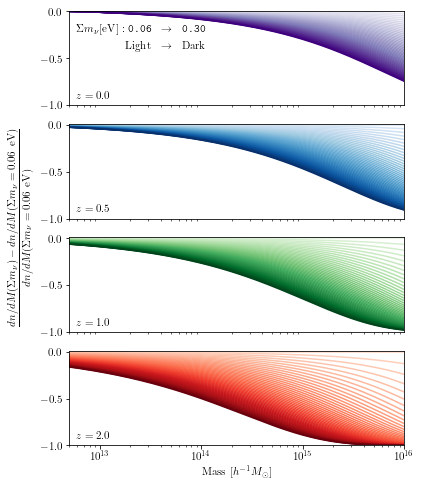

In [19]:

emulator = AemulusNu_HMF_Emulator()

fig = plt.figure(figsize=(6,8), facecolor='w')



meta_ax = fig.add_subplot(111)    # The big subplot
meta_ax.spines['top'].set_color('none')
meta_ax.spines['bottom'].set_color('none')
meta_ax.spines['left'].set_color('none')
meta_ax.spines['right'].set_color('none')
meta_ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

meta_ax.set_ylabel(r'$$\frac{dn/dM(\Sigma m_\nu) - dn/dM(\Sigma m_\nu = 0.06\ {\rm eV})}{dn/dM(\Sigma m_\nu = 0.06\ {\rm eV})}$$'+'\n',)
axs = [fig.add_subplot(411), fig.add_subplot(412),fig.add_subplot(413),fig.add_subplot(414)]


fiducial_cosmology = {'10^9 As':2.09681,
                      'ns': 0.9652,
                      'H0': 67.37,
                      'w0': -1,
                      'ombh2': 0.02233,
                      'omch2': 0.1198,
                      'nu_mass_ev': 0.06,}

fiducial_cosmo_vals = get_cosmo_vals(fiducial_cosmology)

fiducial_ccl_cosmo = get_ccl_cosmology(tuple(fiducial_cosmo_vals))
h = fiducial_cosmology['H0']/100

redshifts = [0.0, 0.5, 1.0, 2.0]


starts = [2.33333333, 2, 1.33333333, 0]


l_cmaps = reversed(['Reds', 'Greens', 'Blues', 'Purples'])
import matplotlib as mpl
crossover_data = {}
for c_cmaps, curr_redshift, curr_ax in (zip(l_cmaps, redshifts, axs)): 


    nm_fiducial = emulator(fiducial_ccl_cosmo, M/h, redshiftToScale(curr_redshift)) 

    curr_ax.text(.02, .05,
            s=r'$z=%.1f$'%(curr_redshift),
            transform=curr_ax.transAxes,
            horizontalalignment='left',
            verticalalignment='bottom',
           fontsize=11)
    crossover_data[curr_redshift] = []

    nu_masses = np.arange(0.06, 0.31, .005)
    cmap = mpl.colormaps[c_cmaps].resampled(len(nu_masses)+10)
#     sns.cubehelix_palette(len(nu_masses), start=c_starts, light=.8)
#     print(cmap[0])
    for c_idx, c_nu_mass_ev in tqdm(enumerate(nu_masses)):

        curr_cosmology = {'10^9 As':2.09681,
                              'ns': 0.9652,
                              'H0': 67.37,
                              'w0': -1,
                              'ombh2': 0.02233,
                              'omch2': 0.1198,
                              'nu_mass_ev': c_nu_mass_ev,}

        curr_cosmo_vals = get_cosmo_vals(curr_cosmology)
        curr_ccl_cosmo = get_ccl_cosmology(tuple(curr_cosmo_vals))

        curr_OL = curr_ccl_cosmo["Omega_l"]
        curr_Om = curr_ccl_cosmo["Omega_m"]
        
        FS_MASS = R_FS_to_M_FS(curr_OL, 
                             curr_Om, 
                             curr_redshift, 
                             c_nu_mass_ev/3)

        if(tuple(curr_cosmo_vals + [curr_redshift]) not in precomputed):
            nm = emulator(curr_ccl_cosmo, M/h, redshiftToScale(curr_redshift))
            precomputed[tuple(curr_cosmo_vals + [curr_redshift])] = nm
        nm = precomputed[tuple(curr_cosmo_vals + [curr_redshift])]

        h = curr_cosmology['H0']/100

        CURR_DATA = (nm-nm_fiducial)/nm_fiducial
        lowest_idx = np.argmin(np.abs(CURR_DATA))
        
#         print('%.2e, %.2e'%(FS_MASS, M[lowest_idx]))
        crossover_data[curr_redshift]  += [[FS_MASS, M[lowest_idx]]]
        curr_ax.plot(M, CURR_DATA, color=cmap(c_idx+10))#, label=mf.name)
#         curr_ax.axvline(M[lowest_idx], color=cmap[c_idx])#, label=mf.name)


    curr_ax.set_xscale('log')
#     curr_ax.set_yscale('symlog', linthresh=1e-4)
    curr_ax.set_ylim(-1, 0.01)
    curr_ax.set_xlim(5e12, 1e16)
    curr_ax.set_yticks([0, -0.5, -1])
        
for c_ax in axs[:-1]:
    c_ax.set_xticks([])
tmps = r'\begin{eqnarray*}\Sigma m_\nu[{\rm eV}]: \texttt{0.06}&\rightarrow &\texttt{0.30}\\\textrm{Light}&\rightarrow &\textrm{Dark}\end{eqnarray*}'
axs[0].text(.02, .85,
        s=tmps,#r'Light $\rightarrow$ Dark' + '\n' + r'$\Sigma m_\nu \ [{\rm eV}]: 0.06 \rightarrow 0.3$',
        transform=axs[0].transAxes,
        horizontalalignment='left',
        verticalalignment='top',
       fontsize=11)

    
axs[-1].set_xlabel(r'Mass $[h^{-1} M_\odot]$')
plt.savefig('frac_change_in_dndM_wrt_mnu.pdf', bbox_inches='tight')
plt.savefig('frac_change_in_dndM_wrt_mnu.png', bbox_inches='tight')

# plt.ylabel(r'$\frac{\textrm{Mass Function}(\Sigma m_\nu)}{\textrm{Mass Function}(\Sigma m_\nu = 0.06\ {\rm eV})}$')

50it [00:00, 1819.97it/s]
50it [00:00, 1831.65it/s]
50it [00:00, 1851.36it/s]
50it [00:00, 1797.80it/s]


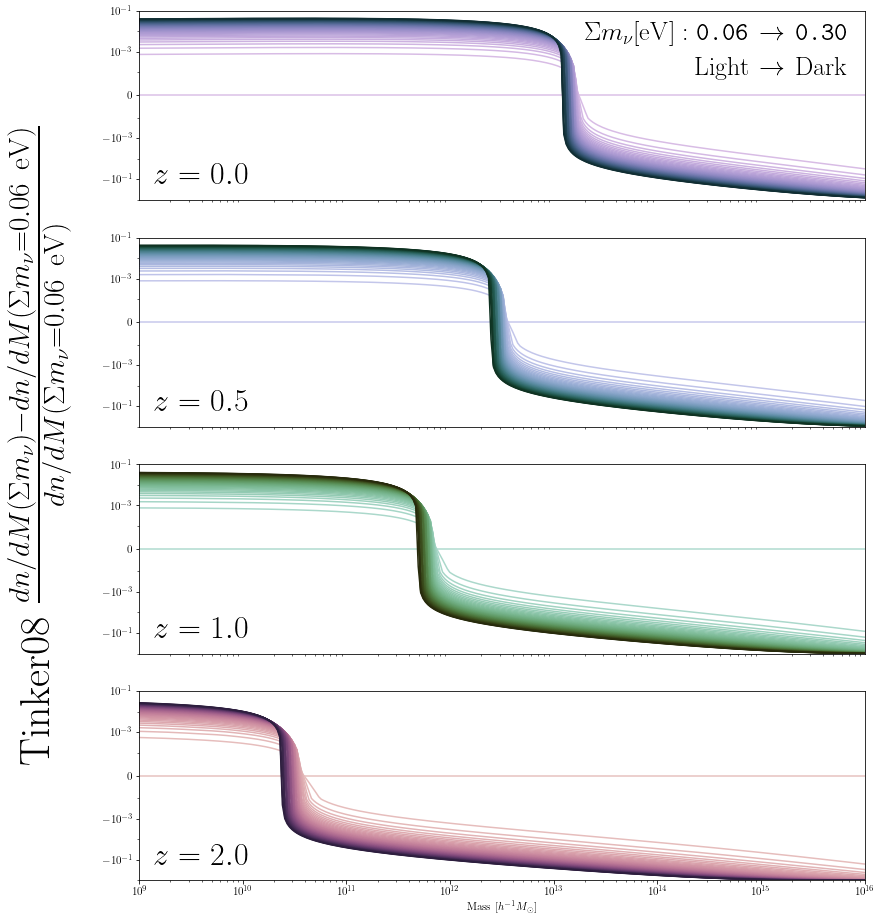

In [9]:

emulator = ccl.halos.MassFuncTinker08(mass_def='200m', mass_def_strict=False)

fig = plt.figure(figsize=(13,16), facecolor='w')



meta_ax = fig.add_subplot(111)    # The big subplot
meta_ax.spines['top'].set_color('none')
meta_ax.spines['bottom'].set_color('none')
meta_ax.spines['left'].set_color('none')
meta_ax.spines['right'].set_color('none')
meta_ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

meta_ax.set_ylabel(r'Tinker08 $\frac{dn/dM(\Sigma m_\nu) - dn/dM(\Sigma m_\nu = 0.06\ {\rm eV})}{dn/dM(\Sigma m_\nu = 0.06\ {\rm eV})}$'+'\n',
                  fontsize=42)
axs = [fig.add_subplot(411), fig.add_subplot(412),fig.add_subplot(413),fig.add_subplot(414)]


fiducial_cosmology = {'10^9 As':2.09681,
                      'ns': 0.9652,
                      'H0': 67.37,
                      'w0': -1,
                      'ombh2': 0.02233,
                      'omch2': 0.1198,
                      'nu_mass_ev': 0.06,}

fiducial_cosmo_vals = get_cosmo_vals(fiducial_cosmology)

fiducial_ccl_cosmo = get_ccl_cosmology(tuple(fiducial_cosmo_vals))


redshifts = [0.0, 0.5, 1.0, 2.0]


starts = [2.33333333, 2, 1.33333333, 0]



for c_starts, curr_redshift, curr_ax in (zip(starts, redshifts, axs)): 


    nm_fiducial = emulator(fiducial_ccl_cosmo, M/h, redshiftToScale(curr_redshift)) 

    curr_ax.text(.02, .05,
            s=r'$z=%.1f$'%(curr_redshift),
            transform=curr_ax.transAxes,
            horizontalalignment='left',
            verticalalignment='bottom',
           fontsize=32)


    nu_masses = np.arange(0.06, 0.31, .005)
    cmap = sns.cubehelix_palette(len(nu_masses), start=c_starts, light=.8)
    for c_idx, c_nu_mass_ev in tqdm(enumerate(nu_masses)):

        curr_cosmology = {'10^9 As':2.09681,
                              'ns': 0.9652,
                              'H0': 67.37,
                              'w0': -1,
                              'ombh2': 0.02233,
                              'omch2': 0.1198,
                              'nu_mass_ev': c_nu_mass_ev,}

        curr_cosmo_vals = get_cosmo_vals(curr_cosmology)

        curr_ccl_cosmo = get_ccl_cosmology(tuple(curr_cosmo_vals))
        nm = emulator(curr_ccl_cosmo, M/h, redshiftToScale(curr_redshift))

        h = curr_cosmology['H0']/100

        
        curr_ax.plot(M, (nm-nm_fiducial)/nm_fiducial, color=cmap[c_idx])#, label=mf.name)

    curr_ax.set_xscale('log')
    curr_ax.set_yscale('symlog', linthresh=1e-4)
    curr_ax.set_ylim(-1, 0.1)
    curr_ax.set_xlim(1e9, 1e16)
    curr_ax.set_yticks([-1e-1, -1e-3, 0, 1e-3, 1e-1])
        
for c_ax in axs[:-1]:
    c_ax.set_xticks([])
tmps = r'\begin{eqnarray*}\Sigma m_\nu[{\rm eV}]: \texttt{0.06}&\rightarrow &\texttt{0.30}\\\textrm{Light}&\rightarrow &\textrm{Dark}\end{eqnarray*}'
axs[0].text(.98, .95,
        s=tmps,#r'Light $\rightarrow$ Dark' + '\n' + r'$\Sigma m_\nu \ [{\rm eV}]: 0.06 \rightarrow 0.3$',
        transform=axs[0].transAxes,
        horizontalalignment='right',
        verticalalignment='top',
       fontsize=26)

    
axs[-1].set_xlabel(r'Mass $[h^{-1} M_\odot]$')
# axs[0].set_title('Tinker08')
plt.savefig('frac_change_in_dndM_wrt_mnu_tinker08.pdf', bbox_inches='tight')


In [10]:
# nu_masses = np.arange(0.06, 0.31, .005)
# fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(13,32), sharex=True, facecolor='w')

# for curr_redshift, curr_ax in (zip(redshifts, axs)): 
#     curr_ax.plot(nu_masses,np.array(crossover_data[curr_redshift]).T[0], label=r'$\frac 4 3 \pi \left(R_{\rm fs} = \frac{1}{k_{\rm fs}}\right)^3 \bar\rho_m(z)$')
#     curr_ax.plot(nu_masses[1:],np.array(crossover_data[curr_redshift]).T[1][1:], label='roughly where curve crosses zero')
#     curr_ax.legend(frameon=False)
#     curr_ax.set_title(r'$z=%.1f$'%(curr_redshift))
#     curr_ax.set_yscale('log')
#     curr_ax.set_ylabel(r'Mass $[h^{-1} M_\odot]$')
# axs[-1].set_xlabel(r'$\Sigma m_\nu$')